## Parameter Estimation with AdamW in PyBOP

In this notebook, we demonstrate an example of parameter estimation for a single-particle model using the AdamW optimiser [1][2]. The AdamW optimiser is an algorithm for gradient-based optimisation, combining the advantages of the Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).

[[1]: Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) 

[[2]: Decoupled Weight Decay Regularization](https://doi.org/10.48550/arXiv.1711.05101)

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP and upgrade dependencies:

In [1]:
%pip install --upgrade pip ipywidgets -q
%pip install pybop -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pybamm

import pybop

pybop.plot.PlotlyManager().pio.renderers.default = "notebook_connected"

Let's fix the random seed in order to generate consistent output during development, although this does not need to be done in practice.

In [3]:
np.random.seed(8)

### Generate Synthetic Data

To demonstrate parameter estimation, we first need some data. We will generate synthetic data using the PyBOP forward model, which requires defining a parameter set and the model itself.

#### Defining Parameters and Model

We start by creating an example parameter set and then instantiate the single-particle model (SPM):

In [16]:
parameter_set = pybamm.ParameterValues("Chen2020")
model = pybamm.lithium_ion.SPM()

### Simulating Forward Model

We can then simulate the model using the `predict` method, with a default constant current to generate voltage data.

In [17]:
t_eval = np.arange(0, 900, 2)
sim = pybamm.Simulation(model, parameter_values=parameter_set)
sol = sim.solve(t_eval=t_eval)
voltage = sol["Voltage [V]"](t_eval)
current = sol["Current [A]"](t_eval)

### Adding Noise to Voltage Data

To make the parameter estimation more realistic, we add Gaussian noise to the data.

In [18]:
sigma = 0.001
corrupt_values = voltage.data + np.random.normal(0, sigma, len(t_eval))

## Identify the Parameters

We will now set up the parameter estimation process by defining the datasets for optimisation and selecting the model parameters we wish to estimate.

### Creating Optimisation Dataset

The dataset for optimisation is composed of time, current, and the noisy voltage data:

In [19]:
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": current,
        "Voltage [V]": corrupt_values,
    }
)

### Defining Parameters to Estimate

We select the parameters for estimation and set up their prior distributions and bounds:

In [20]:
parameters = [
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Gaussian(0.6, 0.02),
        bounds=[0.5, 0.8],
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Gaussian(0.48, 0.02),
        bounds=[0.4, 0.7],
    ),
]

### Setting up the Optimisation Problem

With the datasets and parameters defined, we can set up the optimisation problem, its cost function, and the optimiser.

In [ ]:
builder = (
    pybop.builders.Pybamm()
    .set_dataset(dataset)
    .set_simulation(
        model,
        parameter_values=parameter_set,
    )
    .add_cost(pybop.costs.pybamm.SumSquaredError("Voltage [V]", "Voltage [V]"))
)
for param in parameters:
    builder.add_parameter(param)

problem = builder.build()

# Set optimiser and options
options = pybop.PintsOptions(
    verbose=True,
    max_iterations=150,
    max_unchanged_iterations=40,
)
optim = pybop.AdamW(problem, options=options)

NOTE: Boundaries ignored by <class 'pybop.optimisers._adamw.AdamWImpl'>


### Running the Optimisation

We proceed to run the AdamW optimisation algorithm to estimate the parameters:

In [24]:
results = optim.run()

Iter: 1 | Evals: 1 | Best Values: [0.58956159 0.4680783 ] | Best Cost: 4.057956987992693 |
Iter: 2 | Evals: 2 | Best Values: [0.63926681 0.51784426] | Best Cost: 1.72930132778137 |
Iter: 3 | Evals: 3 | Best Values: [0.68198848 0.56429602] | Best Cost: 0.6586769701827999 |
Iter: 4 | Evals: 4 | Best Values: [0.71790524 0.60627075] | Best Cost: 0.18939816996112976 |
Iter: 5 | Evals: 5 | Best Values: [0.74822993 0.64333951] | Best Cost: 0.020923508923571473 |
Iter: 6 | Evals: 6 | Best Values: [0.77401269 0.67540544] | Best Cost: 0.008023964024341225 |
Iter: 7 | Evals: 7 | Best Values: [0.77401269 0.67540544] | Best Cost: 0.008023964024341225 |
Iter: 8 | Evals: 8 | Best Values: [0.77401269 0.67540544] | Best Cost: 0.008023964024341225 |
Iter: 9 | Evals: 9 | Best Values: [0.77401269 0.67540544] | Best Cost: 0.008023964024341225 |
Iter: 10 | Evals: 10 | Best Values: [0.77401269 0.67540544] | Best Cost: 0.008023964024341225 |
Iter: 50 | Evals: 50 | Best Values: [0.91393333 0.64076157] | Best C

### Viewing the Estimated Parameters

After the optimisation, we can examine the estimated parameter values:

In [25]:
results.x  # This will output the estimated parameters

array([0.7864614 , 0.65913352])

## Plotting and Visualisation

PyBOP provides various plotting utilities to visualise the results of the optimisation.

### Comparing System Response

We can quickly plot the system's response using the estimated parameters compared to the target:

In [30]:
# Create a pybamm input current function
current_interpolant = pybamm.Interpolant(t_eval, current, pybamm.t, extrapolate=False)

# Update parameter values with the optimized results, SOC, and current function
identified_parameter_values = results.parameter_values
identified_parameter_values.update({"Current function [A]": current_interpolant})

# Create simulation with the identified parameters
sim = pybamm.Simulation(model, parameter_values=identified_parameter_values)

# Solve with the experiment and initial conditions
sol = sim.solve(t_eval=t_eval)

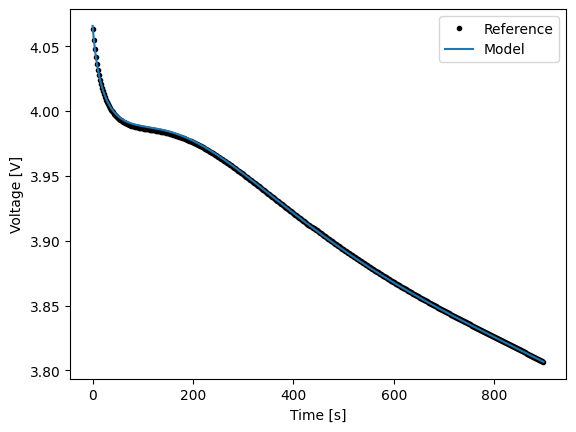

In [ ]:
# Ground truth
plt.plot(t_eval, voltage, "k.", label="Reference")

# PyBaMM solution
t = sol.t
v = sol["Battery voltage [V]"](t)

plt.plot(t, v, label="Model")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

### Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

In [28]:
pybop.plot.convergence(optim)
pybop.plot.parameters(optim);

### Cost Landscape

Finally, we can visualise the cost landscape and the path taken by the optimiser:

In [29]:
# Plot the cost landscape with updated bounds
bounds = np.asarray([[0.6, 0.9], [0.5, 0.8]])
pybop.plot.surface(optim, bounds=bounds);

### Conclusion

This notebook illustrates how to perform parameter estimation using AdamW in PyBOP, providing insights into the optimisation process through various visualisations.